# IMPORT LIBRARIES

In [54]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [55]:
import os

# Prompt user to input the directory path
directory = input(r"Please enter the directory path (use raw string format if needed, e.g., 'C:\path\to\directory'")

# Change to the specified directory
try:
    os.chdir(rf"{directory}")
    print(f"Changed working directory to: {os.getcwd()}")
except FileNotFoundError:
    print("Error: The specified directory does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


Changed working directory to: C:\Users\Veteran\OneDrive - The University of Texas at Dallas\School\MIS 6386 Modeling for Biz Analytics\Group 7\hw03_group07


# QUESTION 1 - REVIEW AND TRANSFORM SKEWED NON-BINARY VARIABLES

## Upload Training Dataset

In [56]:
# import training data and save as pandas dataframe
traindf = pd.read_csv('dmtrain.csv')
# show first 5 rows
print(traindf.head())

   id  n24  rev24  revlast  elpsdm  ordfreq  ordcat  response
0   1    2   30.0     20.0      24        1       6         1
1   2   25  207.0     20.0      24        1       6         0
2   3    5   52.0     15.0      24        1       6         0
3   4   11  105.0     15.0      24        1       6         0
4   5    2   32.0     17.0      24        1       6         0


## Distributions of Non-Binary Variables

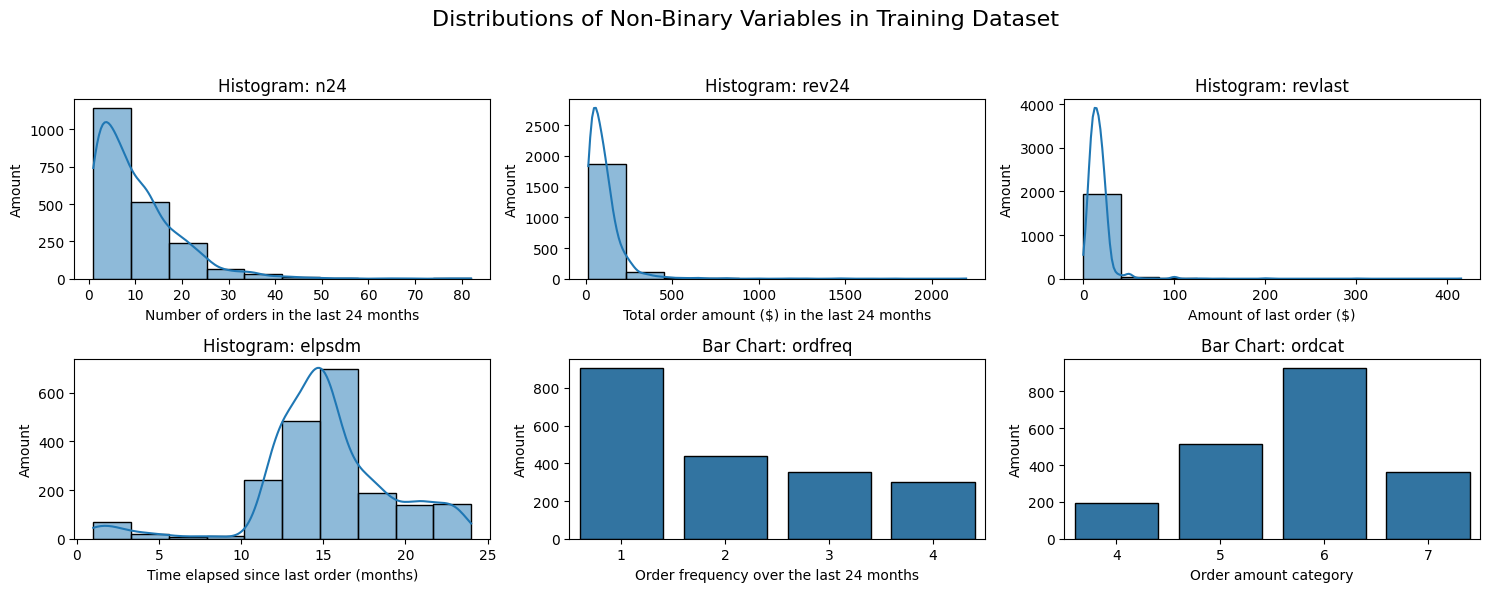

In [57]:
# Define continuous and discrete feature labels
continuous_features = ['n24', 'rev24', 'revlast', 'elpsdm']
continuous_features_labels = ['Number of orders in the last 24 months',
                              'Total order amount ($) in the last 24 months',
                              'Amount of last order ($)',
                              'Time elapsed since last order (months)']
discrete_features = ['ordfreq', 'ordcat']
discrete_features_labels = ['Order frequency over the last 24 months',
                            'Order amount category']

# Calculate total number of plots needed
total_plots = len(continuous_features) + len(discrete_features)

# Set up subplots with dynamic sizing based on total plots
fig, axs = plt.subplots(nrows=(total_plots // 3 + (total_plots % 3 > 0)), ncols=3, figsize=(15,6))

# Flatten axes to easily iterate
axs = axs.flatten()

# Create histograms for continuous features with KDE overlay
for i, col in enumerate(continuous_features):
    sns.histplot(traindf[col], bins=10, edgecolor="black", kde=True, ax=axs[i])
    axs[i].set_title(f'Histogram: {col}', fontsize=12)
    axs[i].set_xlabel(continuous_features_labels[i], fontsize=10)
    axs[i].set_ylabel('Amount', fontsize=10)

# Create bar charts for discrete features
for i, col in enumerate(discrete_features, len(continuous_features)): # indices for discrete features start after continuous
    value_counts = traindf[col].value_counts()
    sns.barplot(value_counts, ax=axs[i], edgecolor = 'black')
    axs[i].set_title(f'Bar Chart: {col}', fontsize=12)
    axs[i].set_xlabel(discrete_features_labels[i - len(continuous_features)], fontsize=10)
    axs[i].set_ylabel('Amount', fontsize=10)

# Adjust layout, title, and ensure proper spacing
plt.suptitle('Distributions of Non-Binary Variables in Training Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout so titles doesn't overlap
plt.show()

In [58]:
# print skewness
for col in (continuous_features + discrete_features):
  skew = traindf[col].skew()
  if abs(skew) > 1:
    print(f'Skewness of {col} is {skew:.6f}.\n{col} is highly skewed.\n')
  elif abs(skew) > 0.5:
    print(f'Skewness of {col} is {skew:.6f}. \n{col} is moderately skewed.\n')
  else:
    print(f'Skewness of {col} is {skew:.6f}. \n{col} is approximately symmetric.\n')

Skewness of n24 is 1.935635.
n24 is highly skewed.

Skewness of rev24 is 7.221135.
rev24 is highly skewed.

Skewness of revlast is 11.968288.
revlast is highly skewed.

Skewness of elpsdm is -0.774676. 
elpsdm is moderately skewed.

Skewness of ordfreq is 0.611939. 
ordfreq is moderately skewed.

Skewness of ordcat is -0.338221. 
ordcat is approximately symmetric.



## Transform Skewed Variables

Handle Potential Non-Positive Values before Log-Transformation

In [59]:
# Check for non-positive values before log-transformation
print((traindf[['n24', 'rev24', 'revlast']] <= 0).any())

n24        False
rev24      False
revlast     True
dtype: bool


In [60]:
# extract records with revlast <= 0
print(traindf[traindf['revlast'] <= 0][['id', 'n24', 'rev24', 'revlast']])

        id  n24  rev24  revlast
1900  1901   15  143.0      0.0
1923  1924   11   64.0      0.0
1959  1960   15  176.0      0.0
1962  1963    9   70.0      0.0
1968  1969    5   75.0      0.0
1972  1973   17  147.0      0.0
1986  1987    1   20.0      0.0
1989  1990   38  257.0      0.0


## Perform Log-Transformation

In [61]:
traindf['log_n24'] = np.log(traindf['n24'])
traindf['log_rev24'] = np.log(traindf['rev24'])
traindf['log_revlast'] = np.log1p(traindf['revlast'])

## Drop Non-Transformed Versions of the Skewed Variables

In [62]:
traindf = traindf.drop(['n24', 'rev24', 'revlast'], axis = 1)
print(traindf.head())

   id  elpsdm  ordfreq  ordcat  response   log_n24  log_rev24  log_revlast
0   1      24        1       6         1  0.693147   3.401197     3.044522
1   2      24        1       6         0  3.218876   5.332719     3.044522
2   3      24        1       6         0  1.609438   3.951244     2.772589
3   4      24        1       6         0  2.397895   4.653960     2.772589
4   5      24        1       6         0  0.693147   3.465736     2.890372


In [63]:
# Print the count of zeros for each column that contains them
for column in traindf.columns:
    count_of_zeros = (traindf[column] == 0).sum()
    if count_of_zeros > 0:
        print(f"Column '{column}' contains {count_of_zeros} zeros.")

Column 'response' contains 1416 zeros.
Column 'log_n24' contains 171 zeros.
Column 'log_revlast' contains 8 zeros.


## Histogram of Log-Transformed Variables

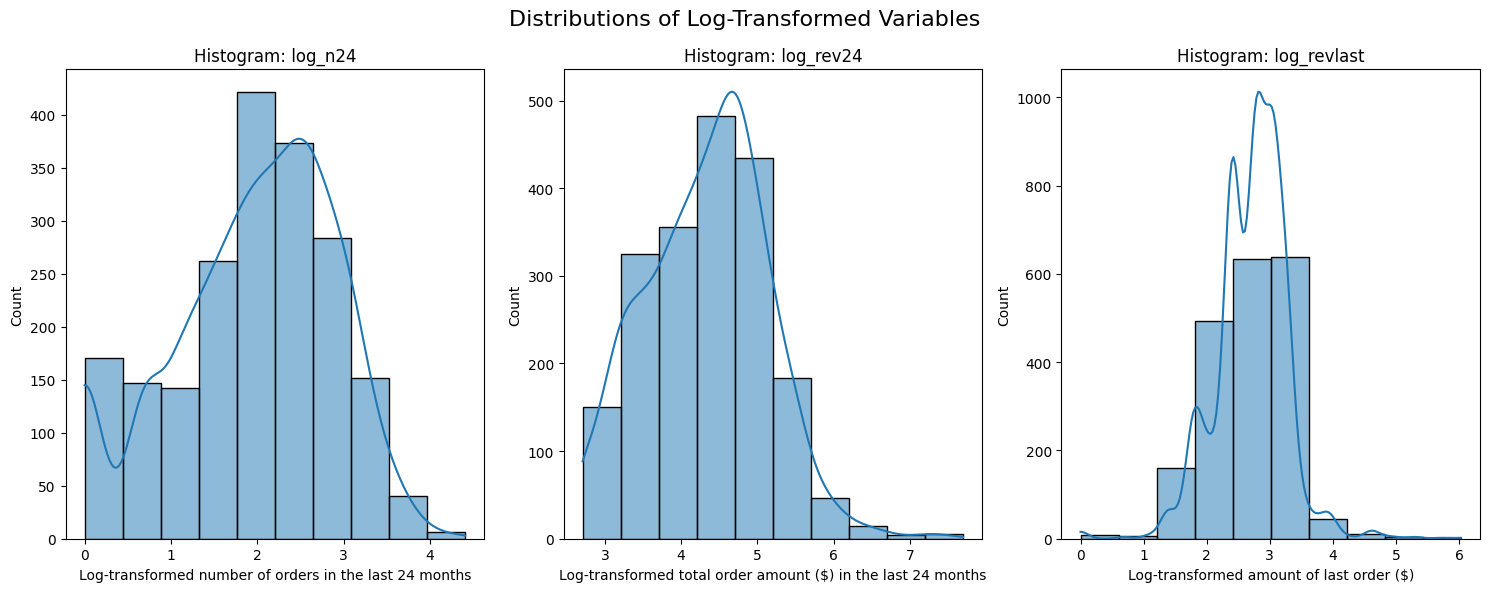

Skewness of log_n24 is -0.442. 
log_n24 is approximately symmetric.

Skewness of log_rev24 is 0.128. 
log_rev24 is approximately symmetric.

Skewness of log_revlast is -0.221. 
log_revlast is approximately symmetric.



In [64]:
# Define log-transformed feature labels
transformed_features = ['log_n24', 'log_rev24', 'log_revlast']
transformed_features_labels = ['Log-transformed number of orders in the last 24 months',
                               'Log-transformed total order amount ($) in the last 24 months',
                               'Log-transformed amount of last order ($)']

# Set up subplots with 1 row and 3 columns
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Create histograms for log-transformed features with KDE
for i, col in enumerate(transformed_features):
    sns.histplot(traindf[col], bins=10, edgecolor="black", kde=True, ax=axs[i])
    axs[i].set_title(f'Histogram: {col}', fontsize=12)
    axs[i].set_xlabel(transformed_features_labels[i], fontsize=10)
    axs[i].set_ylabel('Count', fontsize=10)

# Adjust layout and add a global title
plt.suptitle('Distributions of Log-Transformed Variables', fontsize=16)
plt.tight_layout()
plt.show()

# Print skewness for each log-transformed variable
for col in transformed_features:
    skew = traindf[col].skew()
    if abs(skew) > 1:
        print(f'Skewness of {col} is {skew:.3f}.\n{col} is highly skewed.\n')
    elif abs(skew) > 0.5:
        print(f'Skewness of {col} is {skew:.3f}. \n{col} is moderately skewed.\n')
    else:
        print(f'Skewness of {col} is {skew:.3f}. \n{col} is approximately symmetric.\n')

# QUESTION 2 - DECISION TREE ON ENTIRE DATASET (CRITERION = ENTROPY)

## Generate Decision Tree

In [65]:
# define target variable and independent variables
Xtrain = traindf.copy()
ytrain = Xtrain['response'].to_numpy()
Xtrain = Xtrain.drop(['id', 'response'], axis = 1)

In [66]:
# initialize decision tree classifier
dtree = DecisionTreeClassifier(criterion = 'entropy')

# fit decision tree
dtree.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy')

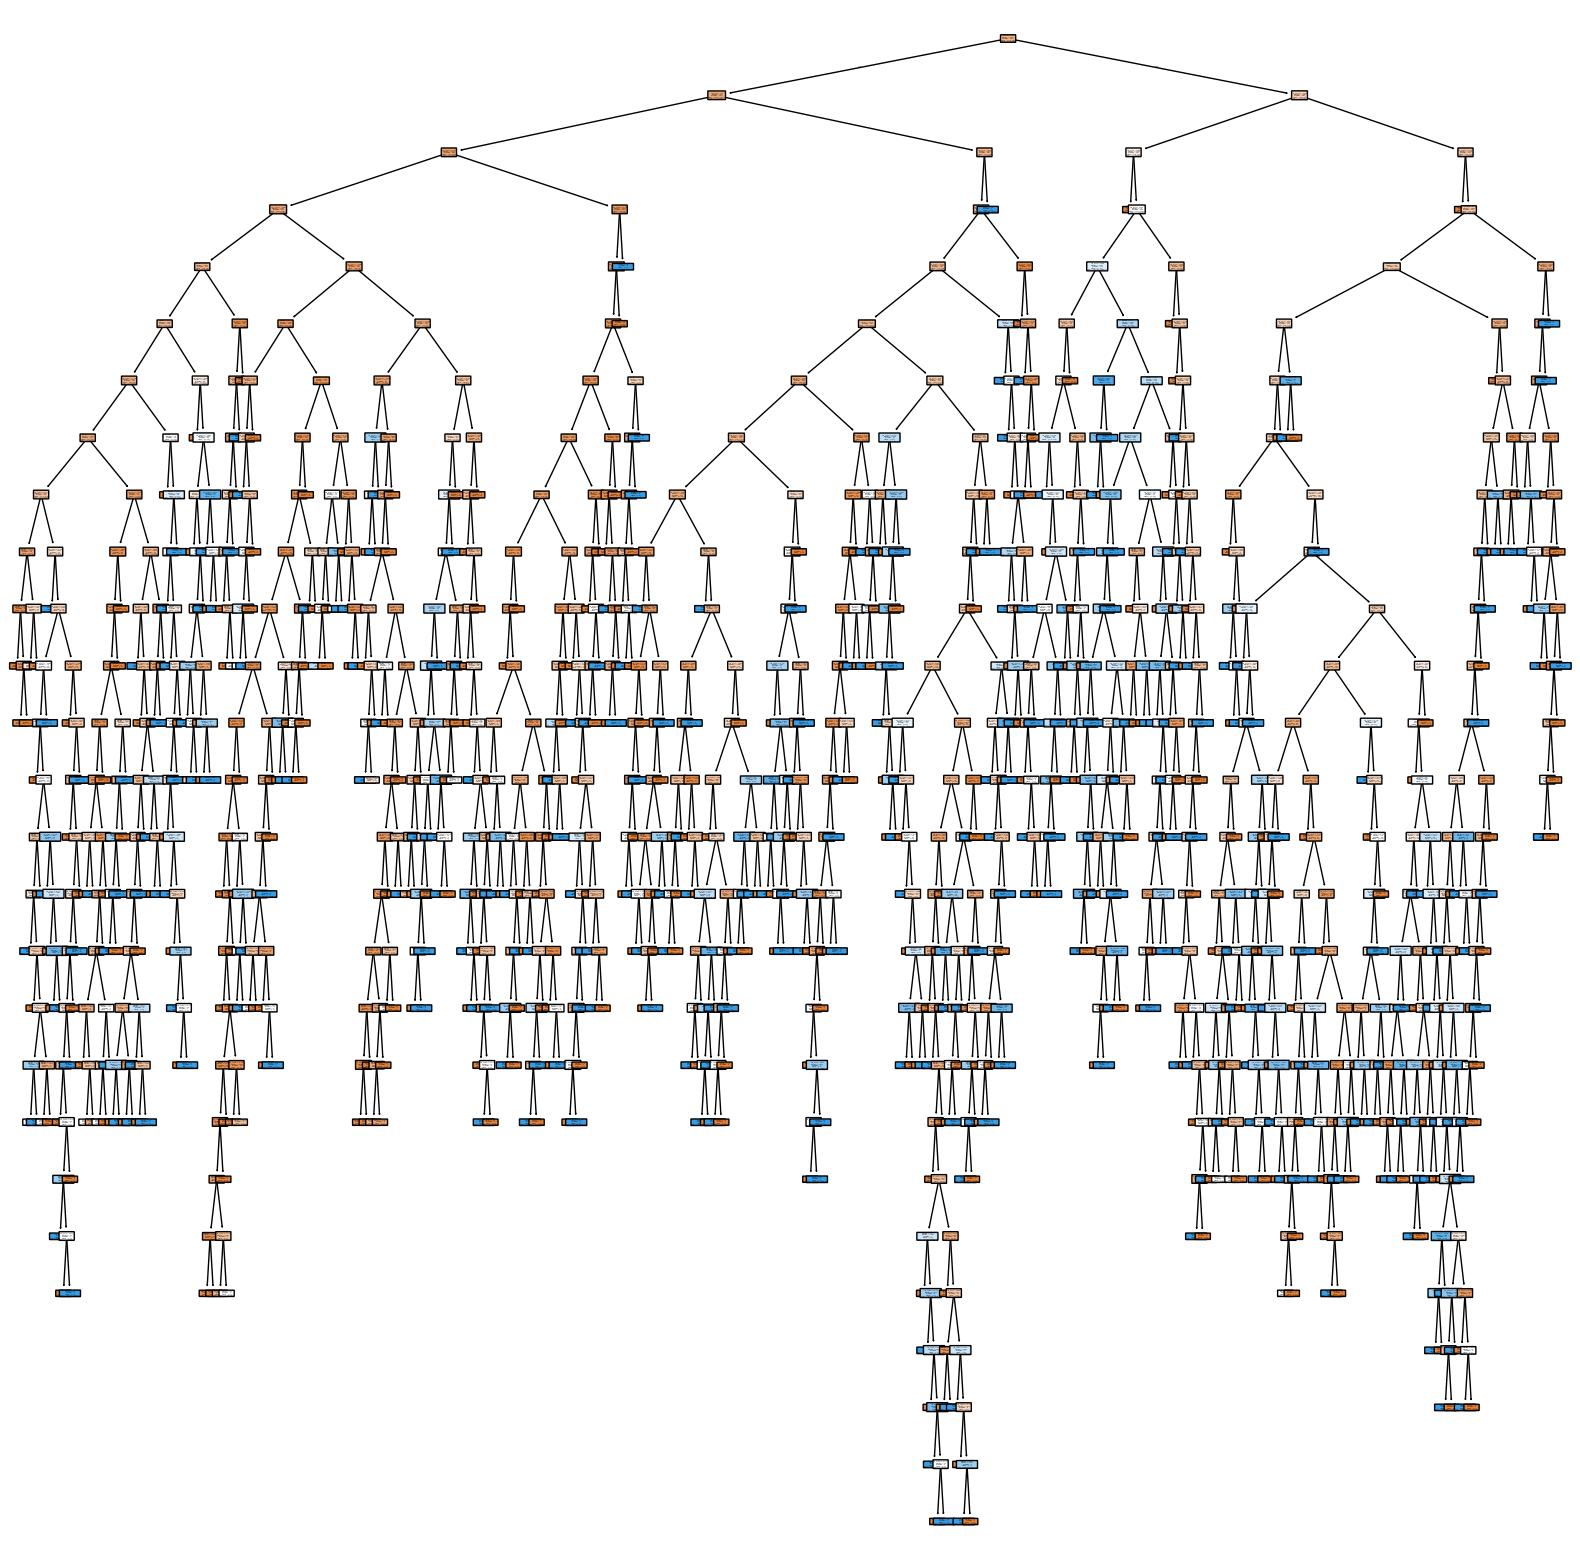

In [67]:
# plot decision tree
plt.figure(figsize=(20,20))
decision_tree = plot_tree(decision_tree = dtree, feature_names = Xtrain.columns, class_names = ['no response', 'customer responded'], filled = True, rounded = True)

## Depth of the Tree Generated

In [68]:
print(f'The depth of the tree generated using entropy on the entire dataset: {dtree.tree_.max_depth}.')

The depth of the tree generated using entropy on the entire dataset: 26.


# QUESTION 3 - IDENTIFY BEST DECISION TREE BY PRUNING AT DIFFERENT DEPTHS

## Set Up 10-Fold Cross Validation

In [69]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

## Accuracy of Decision Trees at Different Max Depths

In [70]:
# create a list of max depths from 1 to 26 (depth of the largest tree generated in Q2)
dtree_max_depths = np.arange(1,27,1)

# define dictionaries to store cross-validation scores and mean accuracies with corresponding max depth
dtree_kf_cvs = {}
dtree_mean_accuracy = {}

for md in dtree_max_depths: # iterate through each max depth
  # initialize decision tree classifier
  dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth = md, random_state = 1)

  # get accuracy scores for each cv fold
  scores = cross_val_score(dtree, Xtrain, ytrain, cv = kf, scoring = 'accuracy')
  dtree_kf_cvs[md] = scores

  # calculate mean accuracy for each max depth
  dtree_mean_accuracy[md] = np.mean(scores)

# sort dictionary of mean accuracies in descending order
dtree_mean_accuracy_sorted = dict(sorted(dtree_mean_accuracy.items(), # return a list the dictionary's key-value pairs as tuples
                                    key = lambda item: item[1], # specify that each tuple is sorted by the value (accuracy)
                                    reverse = True))# descending order


# print max depth and corresponding mean accuracy
dtree_accuracy_summary = pd.DataFrame(dtree_mean_accuracy_sorted.items(), columns = ['Max Depth', 'Accuracy']) # convert dictionary into a list of tuples then convert tuples into df and specify column names
dtree_accuracy_summary['Accuracy'] = dtree_accuracy_summary['Accuracy'].map('{:.2%}'.format) # format accuracy as percentage
print(dtree_accuracy_summary)

    Max Depth Accuracy
0           1   70.80%
1           2   70.80%
2           3   70.40%
3           6   69.95%
4           4   69.75%
5           5   69.65%
6           7   68.95%
7           8   68.30%
8           9   67.45%
9          10   67.10%
10         11   66.50%
11         12   65.90%
12         13   65.20%
13         15   63.95%
14         14   63.55%
15         16   63.55%
16         17   63.50%
17         18   62.75%
18         19   62.50%
19         20   62.20%
20         21   61.75%
21         22   61.75%
22         24   61.55%
23         26   61.55%
24         25   61.05%
25         23   60.60%


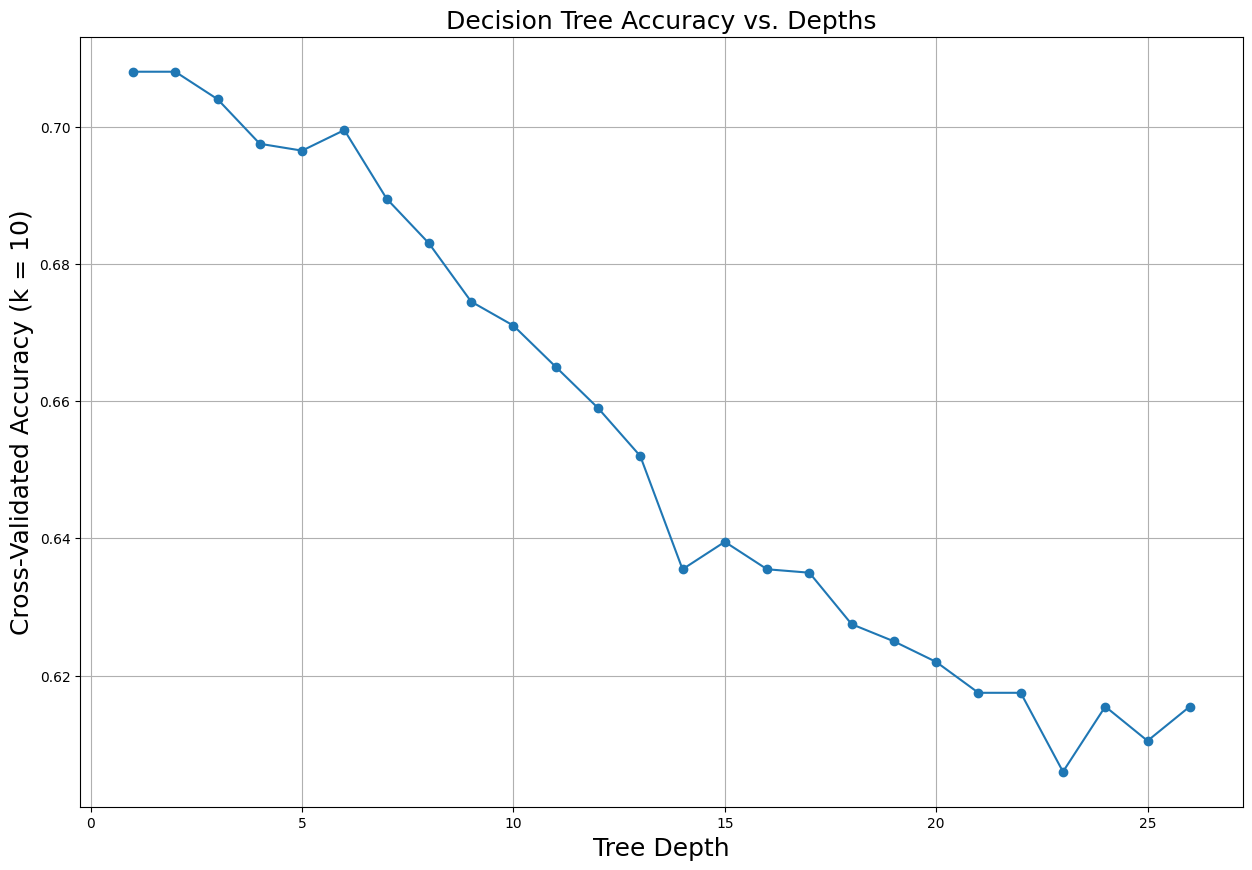

In [71]:
# Extract the depths and accuracies from the original dictionary (unsorted for plotting)
depths = list(dtree_mean_accuracy.keys())
accuracies = list(dtree_mean_accuracy.values())

# Plotting the depths vs accuracies
plt.figure(figsize=(15, 10))
plt.plot(depths, accuracies, marker='o')
plt.xlabel('Tree Depth', fontsize=18)
plt.ylabel('Cross-Validated Accuracy (k = 10)', fontsize=18)
plt.title('Decision Tree Accuracy vs. Depths', fontsize=18)
plt.grid(True)
plt.show()

## 6 Decision Trees with the Highest Mean Accuracy




In [72]:
# extract top 6 max depths
top6_dtree_max_depths = list(dtree_mean_accuracy_sorted.keys())[:6]

# extract corresponding cross-validation scores
top6_dtree_kf_cvs = {md: dtree_kf_cvs[md] for md in top6_dtree_max_depths}

# create box plot labels with max depth, median, and IQR
top6_dtree_labels = []

for md, scores in top6_dtree_kf_cvs.items(): # iterate through each key-value pair of the cross-validation scores dictionary
  iqr = np.percentile(scores,75) - np.percentile(scores,25)
  median = np.median(scores)
  label = f'Max Depth = {md}\nMedian: {median:.2%}\nIQR: {iqr:.2%}'
  top6_dtree_labels.append(label)

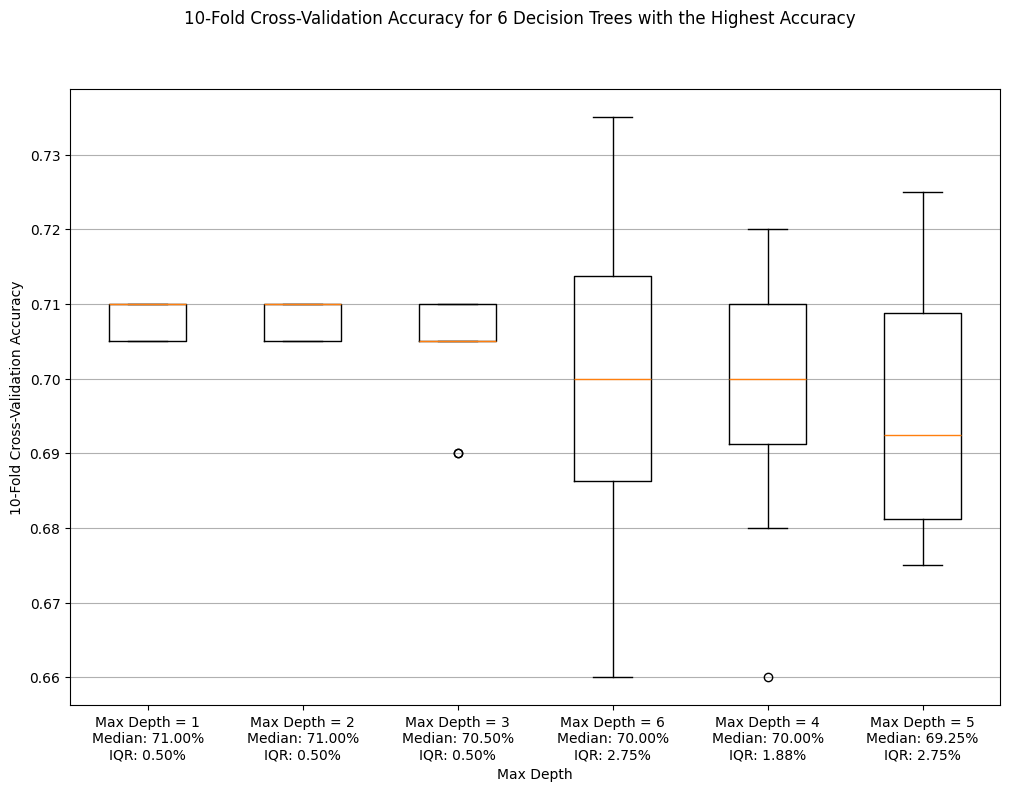

In [73]:
# generate box plots for these top 6 models
fig = plt.figure(figsize=(12,8))
fig.suptitle('10-Fold Cross-Validation Accuracy for 6 Decision Trees with the Highest Accuracy')
ax = fig.add_subplot(1,1,1)
plt.boxplot(top6_dtree_kf_cvs.values(), labels = top6_dtree_labels)
plt.grid(True, axis = 'y')
plt.xlabel('Max Depth')
plt.ylabel('10-Fold Cross-Validation Accuracy')

plt.show()

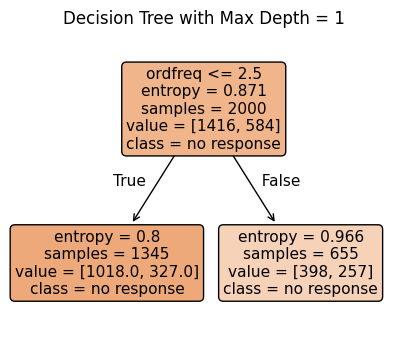

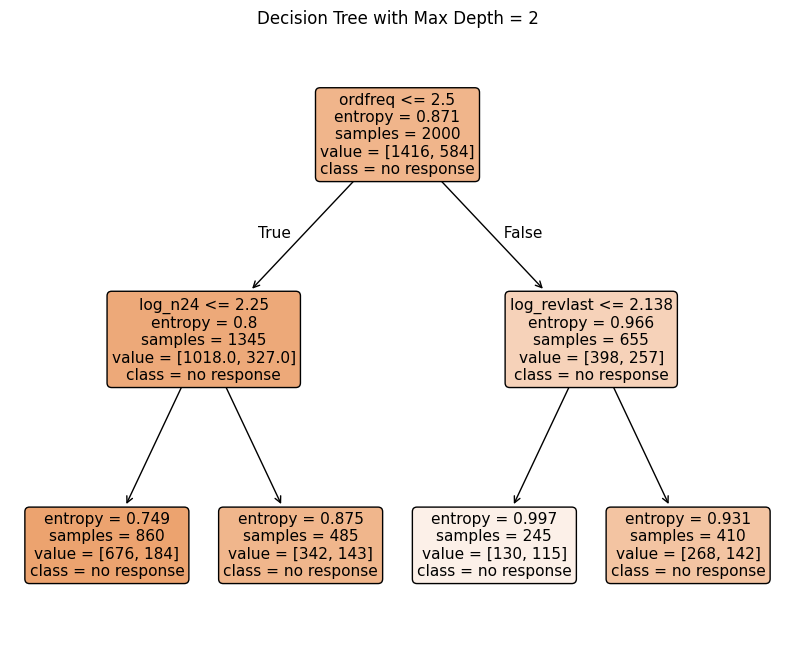

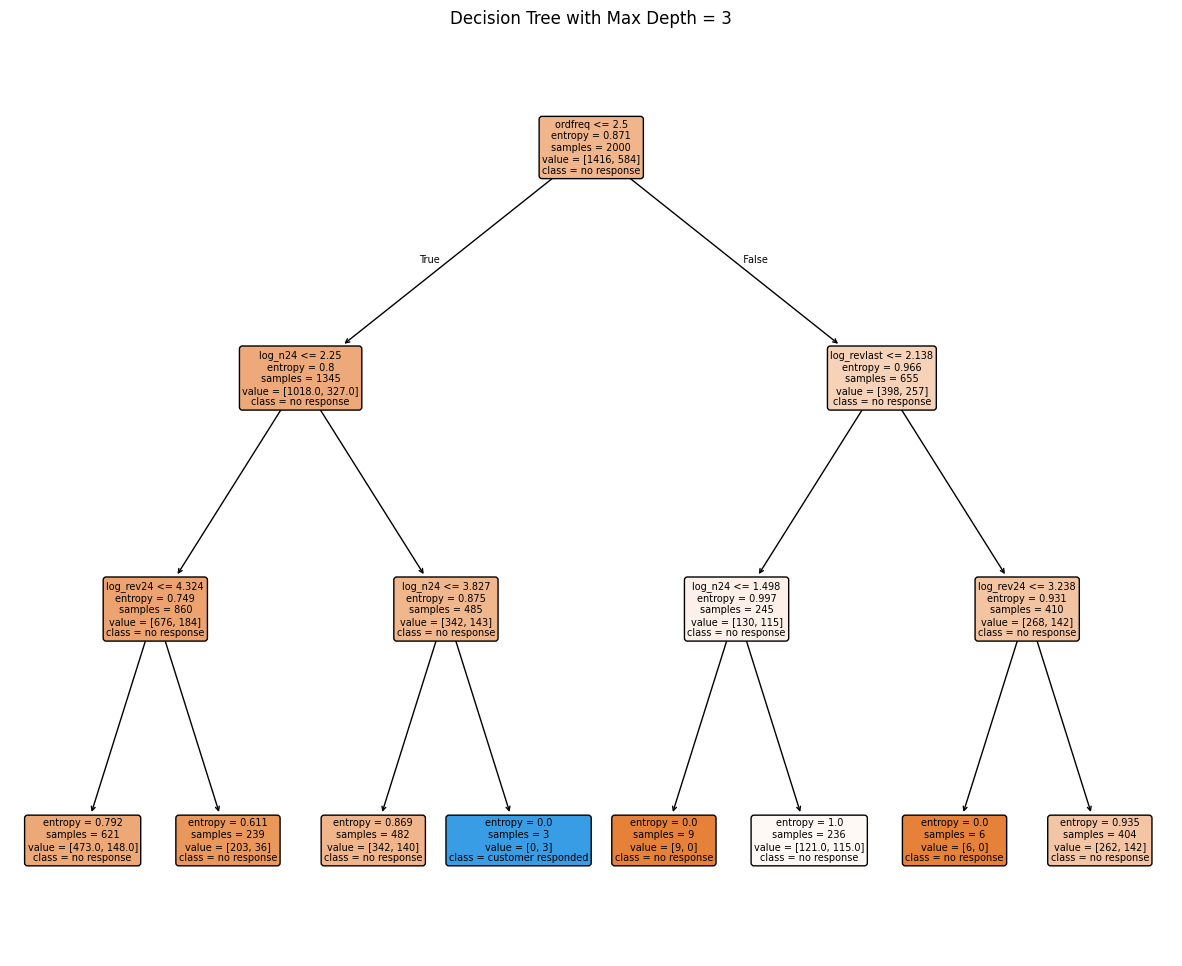

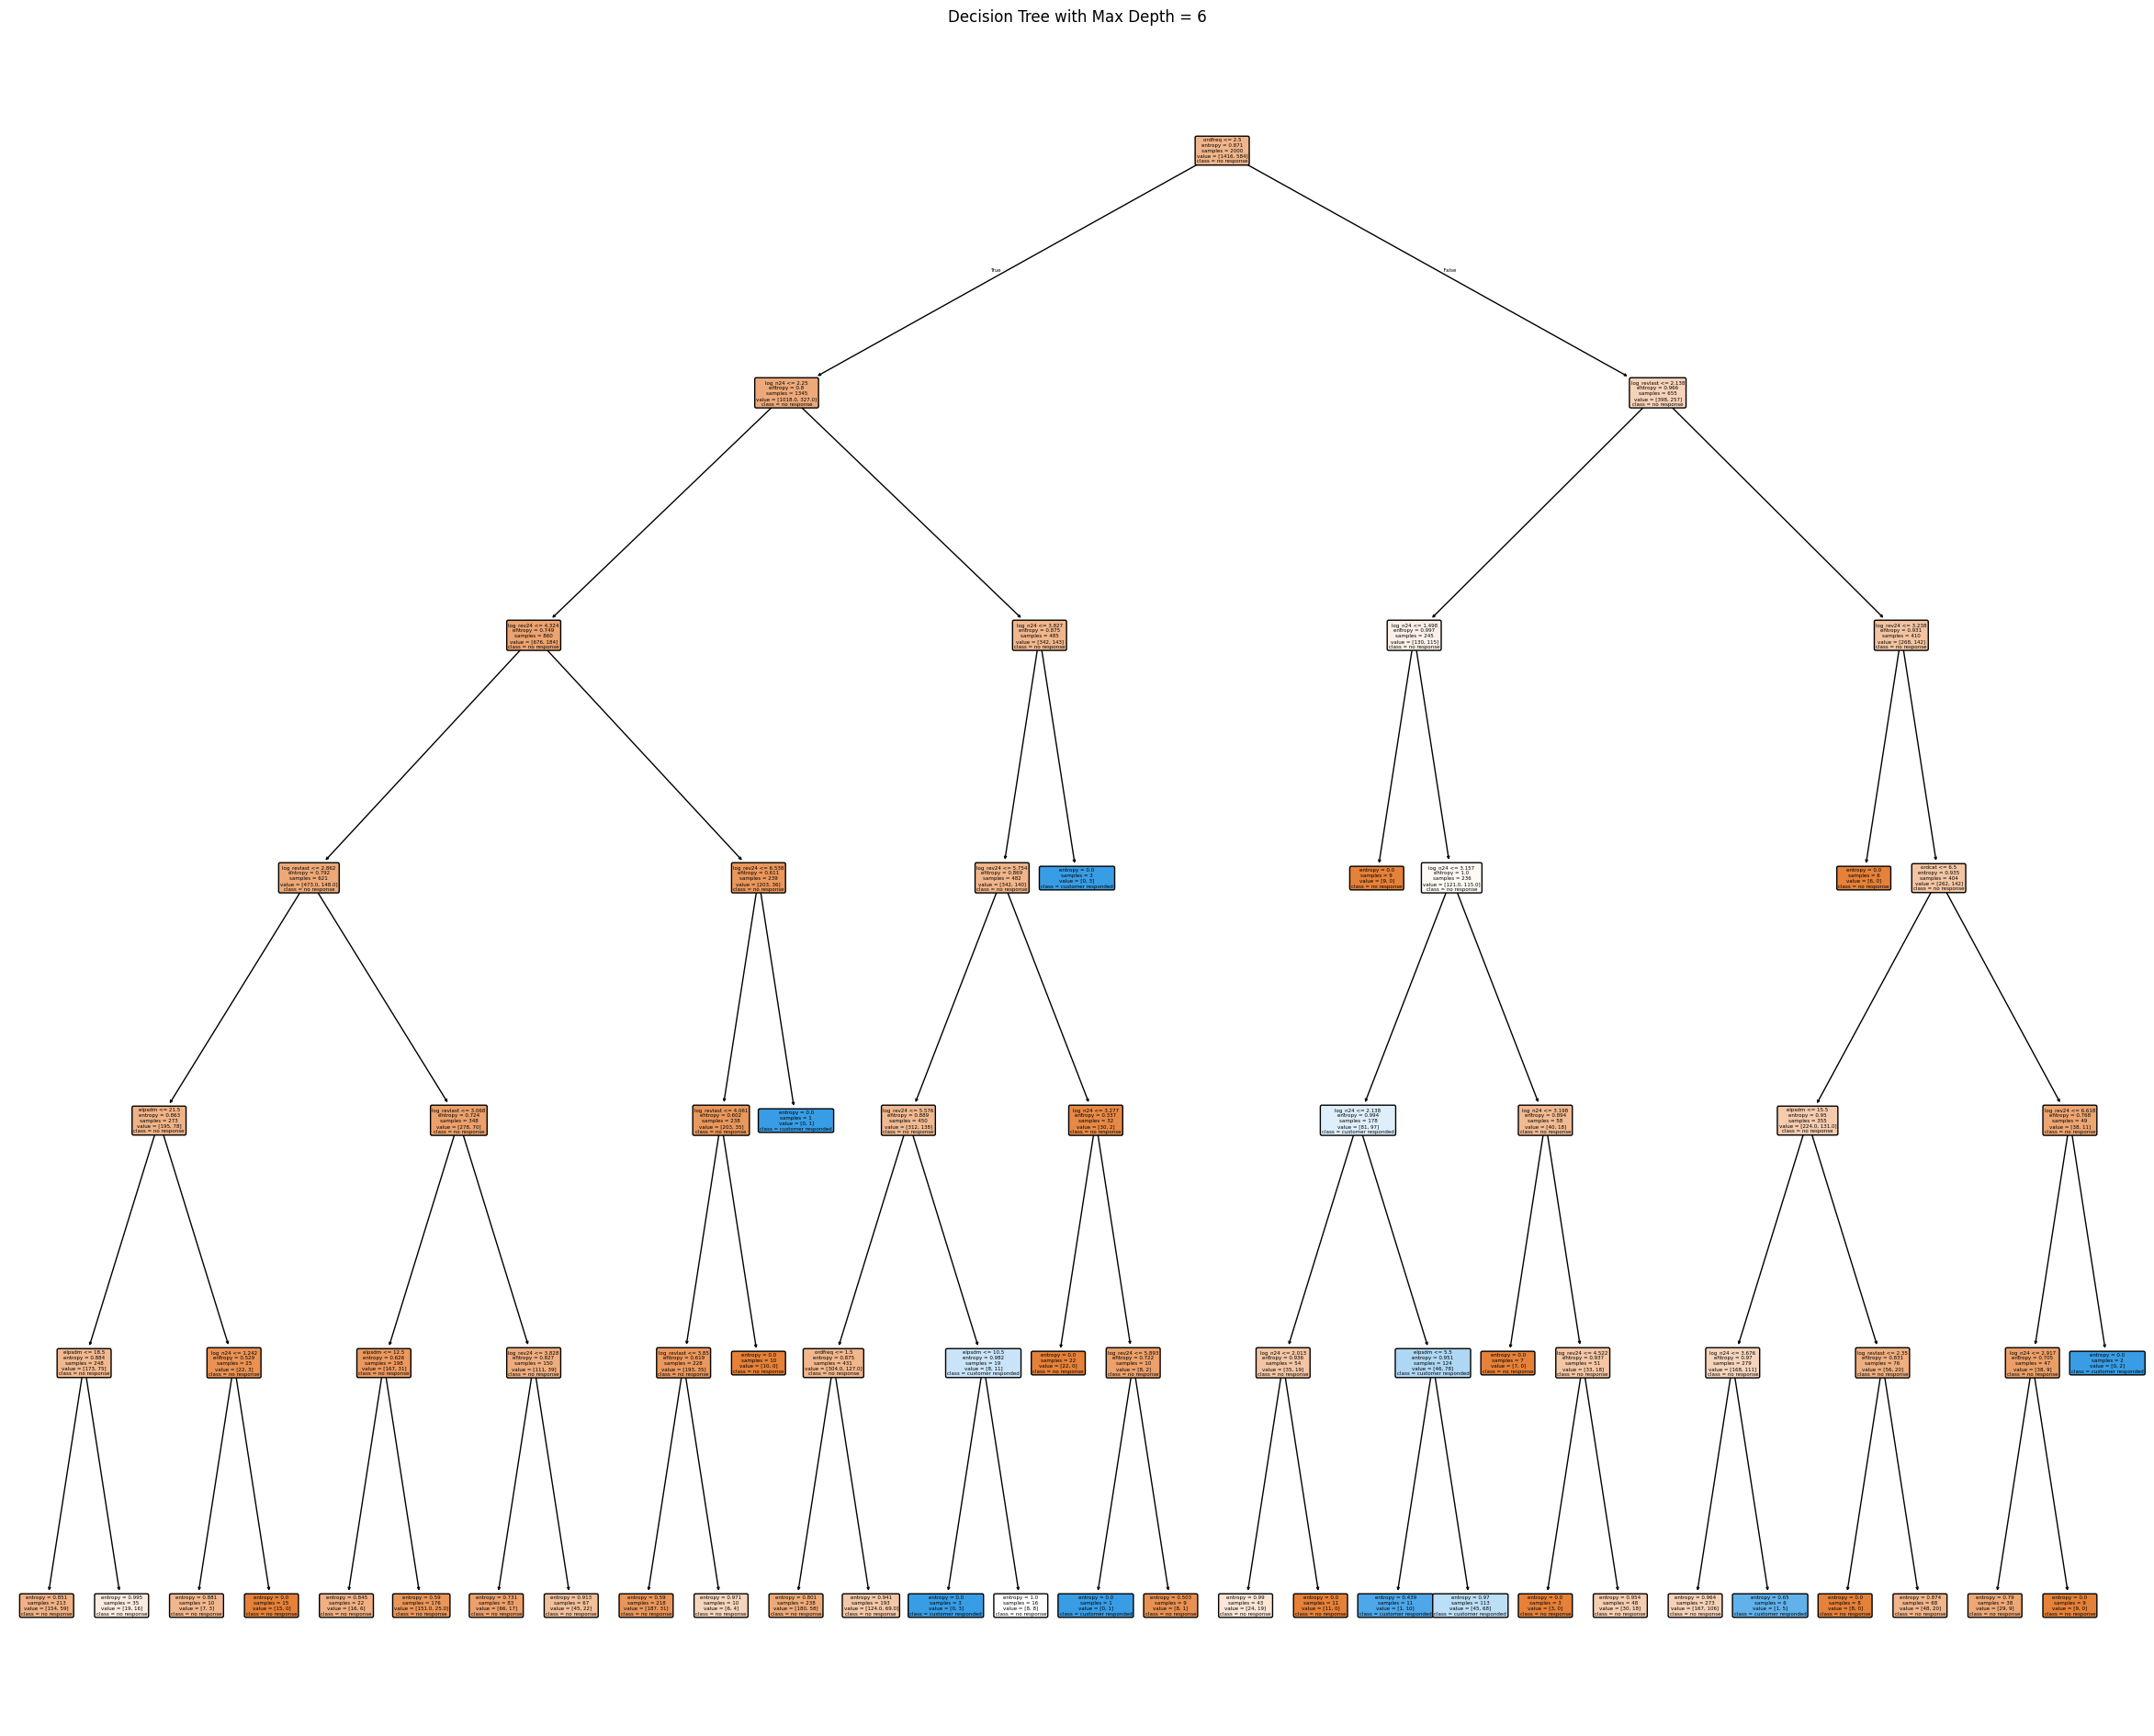

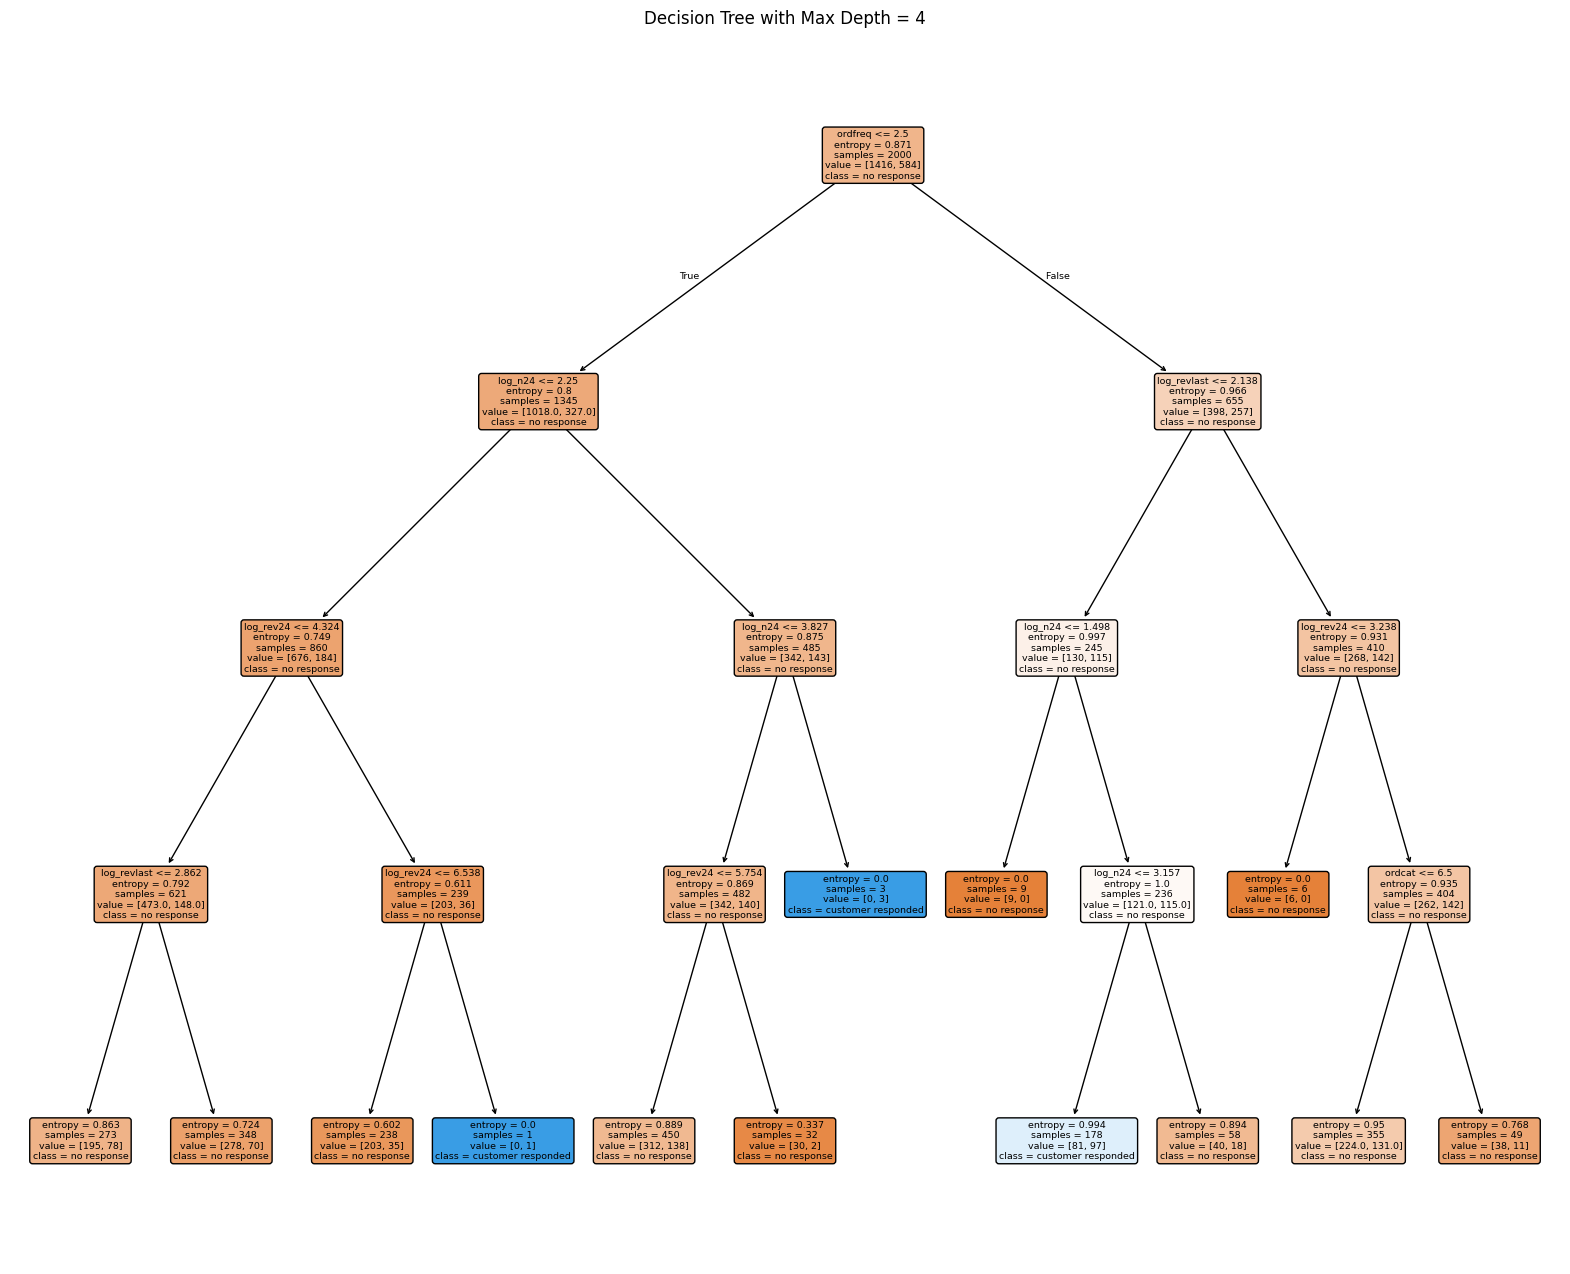

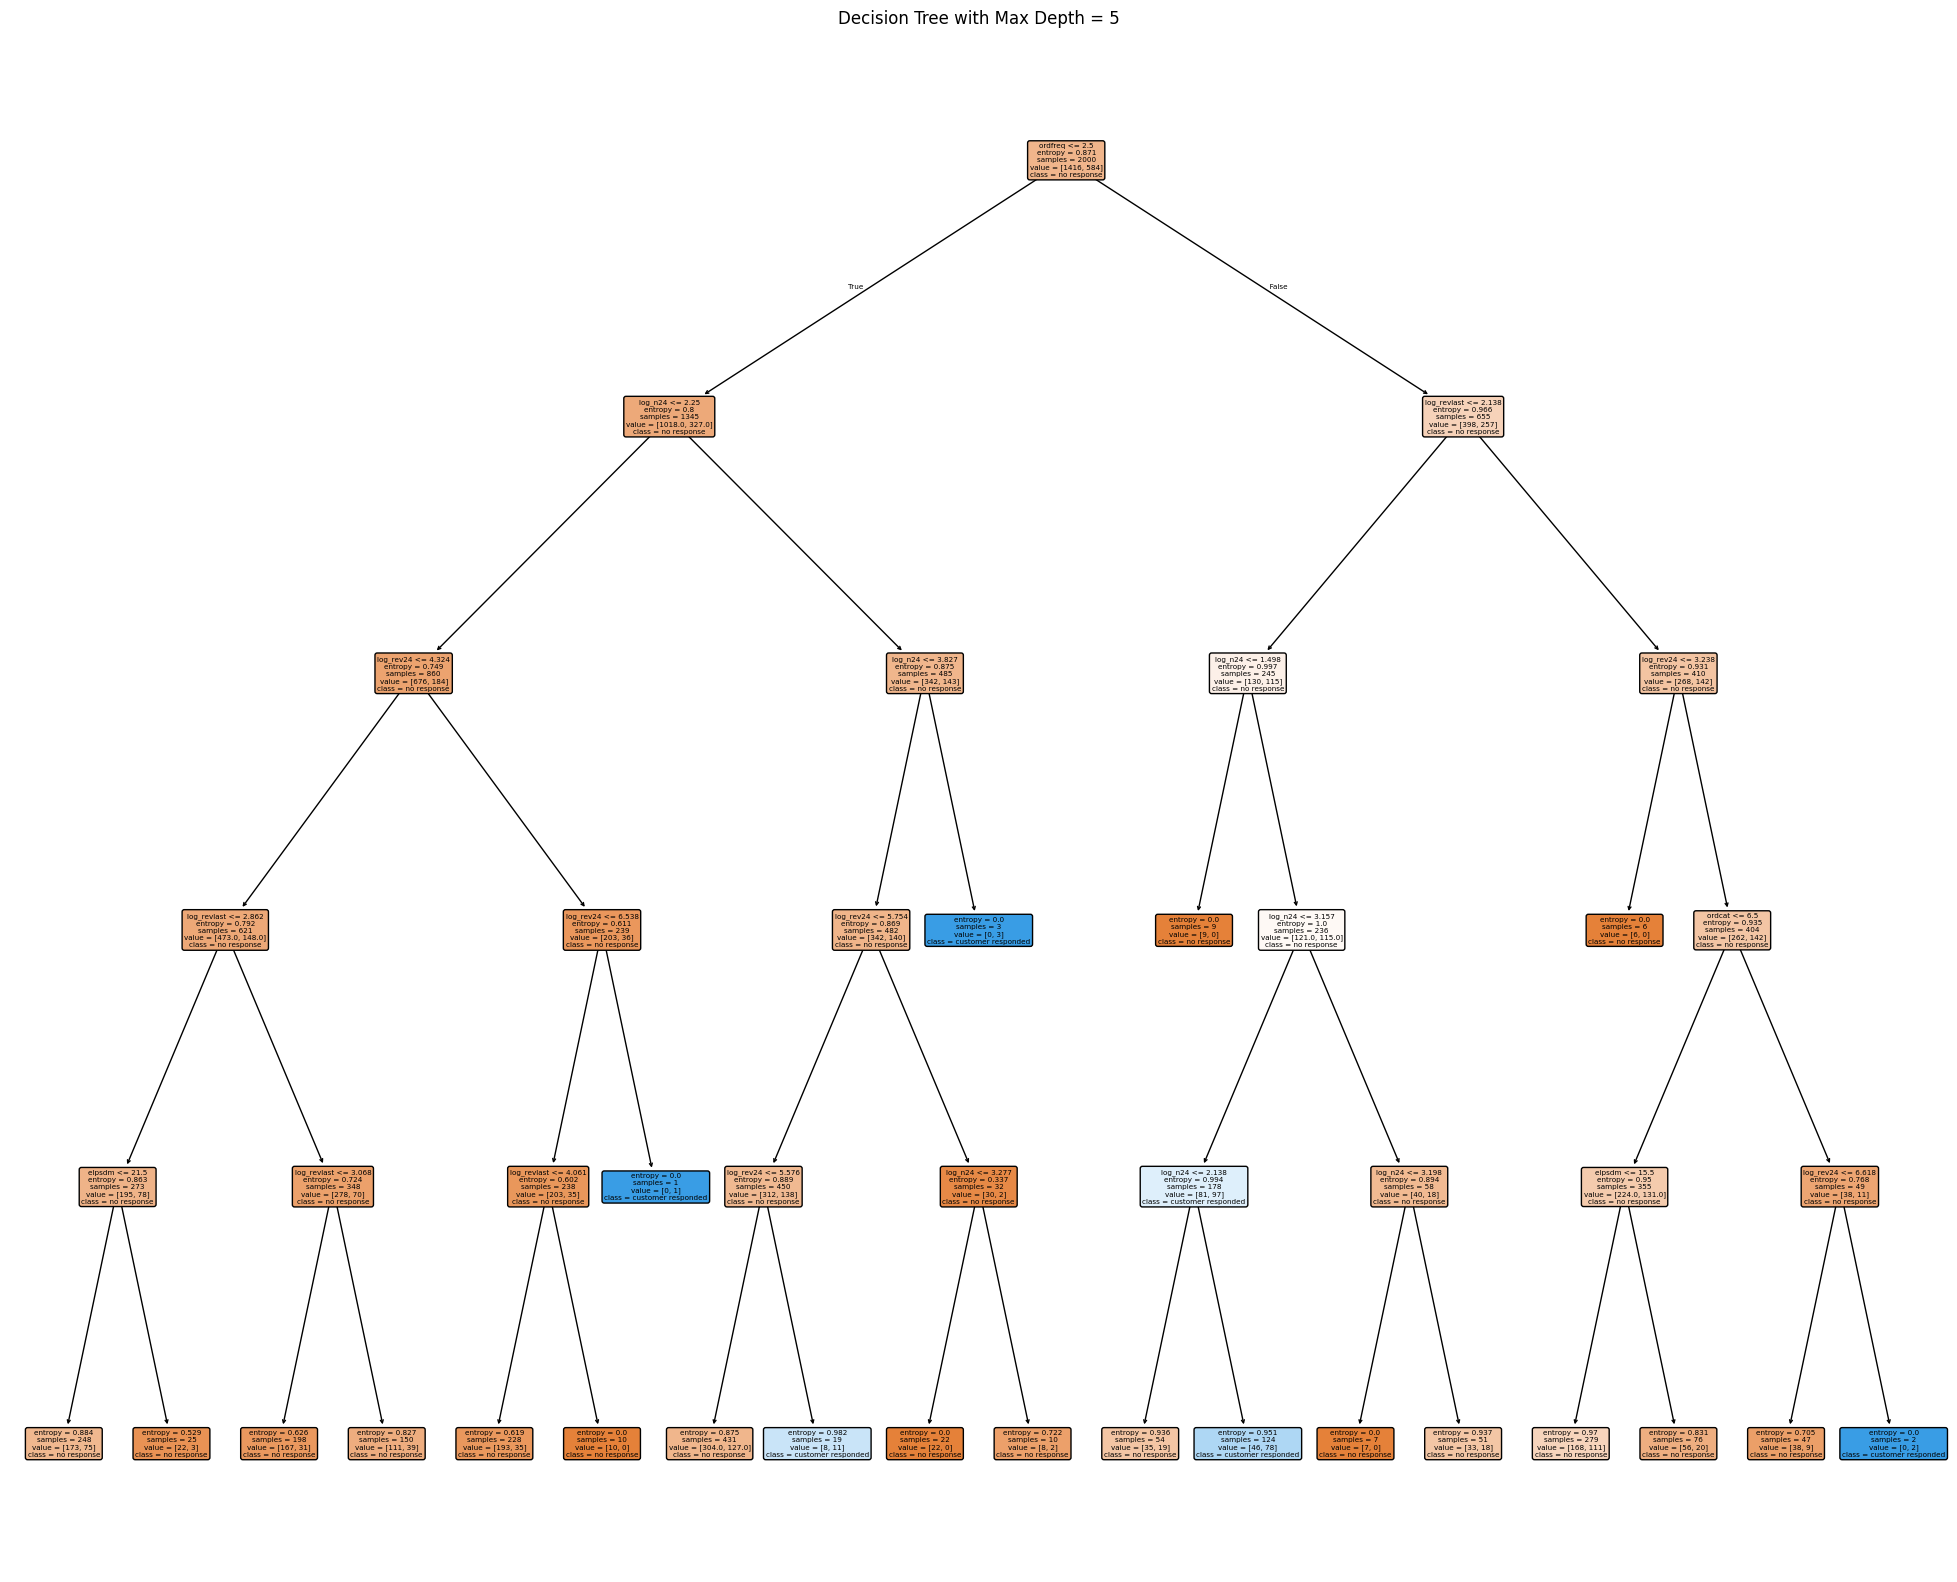

In [74]:
# plot top 6 decision trees
for md in top6_dtree_max_depths:
  plt.figure(figsize=(5*md,4*md)) # figure size proportional to max depth
  dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth = md, random_state = 1)
  dtree.fit(Xtrain, ytrain)
  decision_tree = plot_tree(decision_tree = dtree, feature_names = Xtrain.columns, class_names = ['no response', 'customer responded'], filled = True, rounded = True)
  plt.title(f'Decision Tree with Max Depth = {md}')
  plt.show()

# QUESTION 4 - RANDOM FOREST WITH 100 TREES AND MAX DEPTHS FROM Q3

## Accuracy of Random Forests at Different Max Depths

In [75]:
rf100_max_depths = [1,2,3] # create a list of max depths recommended in Q3
rf100_accuracy = []

for md in rf100_max_depths: # iterate through each max depth
  # initialize random forest classifier
  rf100 = RandomForestClassifier(n_estimators = 100, max_depth = md, criterion = 'entropy', random_state = 1)

  # fit the random forest model
  rf100.fit(Xtrain, ytrain)

  # append rf100_accuracy with accuracy for each max depth
  rf100_accuracy.append(rf100.score(Xtrain, ytrain))

# print max depth and corresponding accuracy
rf100_accuracy_summary = pd.DataFrame({'Max Depth': rf100_max_depths,
                                'Accuracy': rf100_accuracy
                                })
rf100_accuracy_summary_sorted = rf100_accuracy_summary.sort_values('Accuracy', ascending = False)
rf100_accuracy_summary_sorted['Accuracy'] = rf100_accuracy_summary_sorted['Accuracy'].map('{:.2%}'.format) # format accuracy as percentage
print(rf100_accuracy_summary_sorted)

   Max Depth Accuracy
2          3   71.15%
0          1   70.80%
1          2   70.80%


## Best Random Forest Classifier & Comparison to Decision Tree

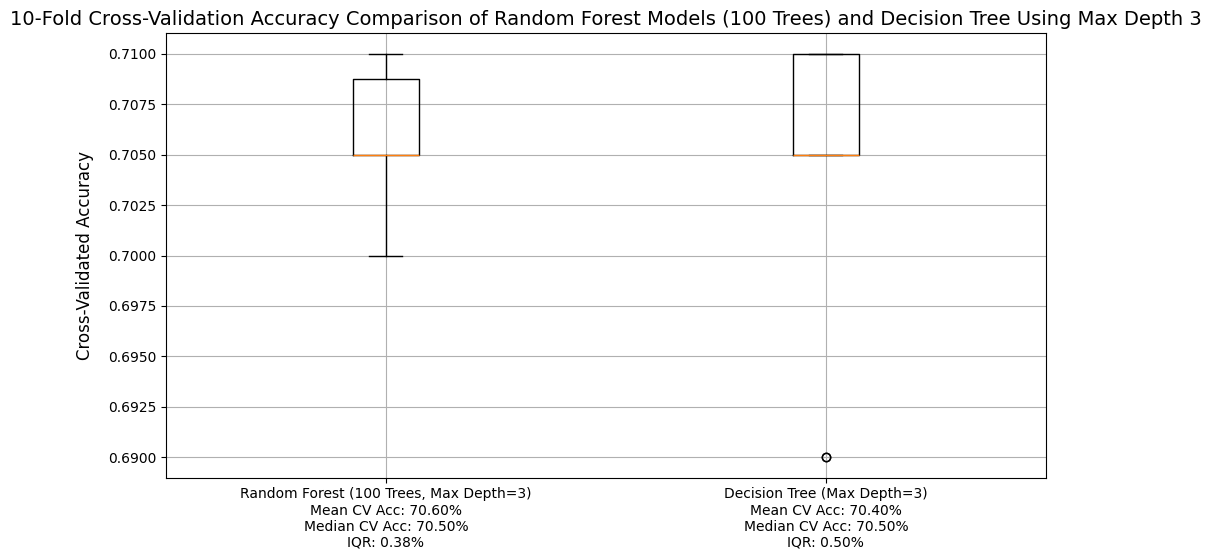

In [76]:
rf100 = RandomForestClassifier(n_estimators=100, max_depth=3, criterion='entropy', random_state=1)
dtree = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=1)

# Perform cross-validation using the same KFold cross-validator for both models
rf100_scores = cross_val_score(rf100, Xtrain, ytrain, cv=kf, scoring='accuracy')
dtree_scores = cross_val_score(dtree, Xtrain, ytrain, cv=kf, scoring='accuracy')

# Create a DataFrame to compare the cross-validation scores
comparison_df = pd.DataFrame({
    'Random Forest (100 Trees, Max Depth=3)': rf100_scores,
    'Decision Tree (Max Depth=3)': dtree_scores
})

# Calculate mean, median, IQR in the boxplot labels
model_scores = [rf100_scores, dtree_scores]

custom_labels = []
for model_name, scores in zip(comparison_df.columns, model_scores):
    mean = np.mean(scores)
    median = np.median(scores)
    iqr = np.percentile(scores, 75) - np.percentile(scores, 25)

    # Create custom label with model name, mean, median, and IQR
    label = (f'{model_name}\nMean CV Acc: {mean:.2%}\nMedian CV Acc: {median:.2%}\n'
             f'IQR: {iqr:.2%}')
    custom_labels.append(label)

# Plot box plots with custom labels
plt.figure(figsize=(10, 6))  # Adjust the figure size to avoid overlap

# Generate the box plot with custom labels
plt.boxplot(model_scores, labels=custom_labels)

# Set title and axis labels
plt.title('10-Fold Cross-Validation Accuracy Comparison of Random Forest Models (100 Trees) and Decision Tree Using Max Depth 3', fontsize=14)
plt.ylabel('Cross-Validated Accuracy', fontsize=12, labelpad=10)

# Add grid and adjust layout to prevent label overlap
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

# QUESTION 5 - RANDOM FOREST WITH 50 TREES AND MAX DEPTHS FROM Q3

## Accuracy of Random Forests at Different Max Depths

In [77]:
rf50_max_depths = [1,2,3] # create a list of max depths recommended in Q3
rf50_accuracy = []

for md in rf50_max_depths: # iterate through each max depth
  # initialize random forest classifier
  rf50 = RandomForestClassifier(n_estimators = 50, max_depth = md, criterion = 'entropy', random_state = 1)

  # fit the random forest model
  rf50.fit(Xtrain, ytrain)

  # append rf50_accuracy with accuracy for each max depth
  rf50_accuracy.append(rf50.score(Xtrain, ytrain))

# print max depth and corresponding accuracy
rf50_accuracy_summary = pd.DataFrame({'Max Depth': rf50_max_depths,
                                'Accuracy': rf50_accuracy
                                })
rf50_accuracy_summary_sorted = rf50_accuracy_summary.sort_values('Accuracy', ascending = False)
rf50_accuracy_summary_sorted['Accuracy'] = rf50_accuracy_summary_sorted['Accuracy'].map('{:.2%}'.format) # format accuracy as percentage
print(rf50_accuracy_summary_sorted)

   Max Depth Accuracy
2          3   71.45%
0          1   70.80%
1          2   70.75%


## Recommendations

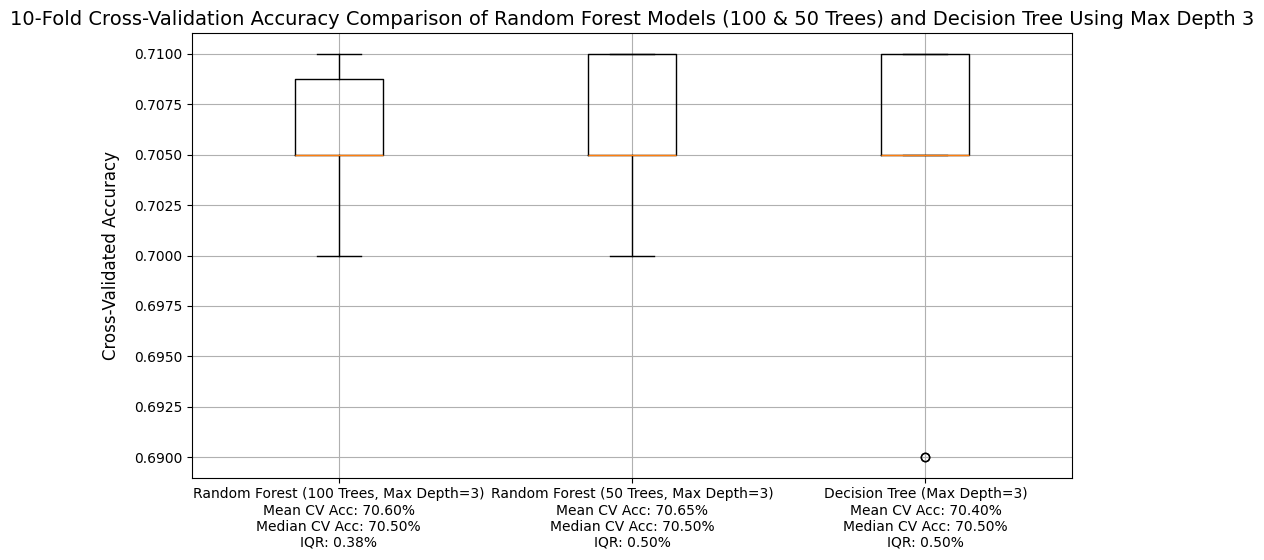

In [78]:
# Initialize classifiers with max depth 3
dtree = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=1)

# Perform cross-validation using the same KFold cross-validator for all models
rf100_scores = cross_val_score(rf100, Xtrain, ytrain, cv=kf, scoring='accuracy')
rf50_scores = cross_val_score(rf50, Xtrain, ytrain, cv=kf, scoring='accuracy')
dtree_scores = cross_val_score(dtree, Xtrain, ytrain, cv=kf, scoring='accuracy')

# Create a DataFrame to compare the scores
comparison_df = pd.DataFrame({
    'Random Forest (100 Trees, Max Depth=3)': rf100_scores,
    'Random Forest (50 Trees, Max Depth=3)': rf50_scores,
    'Decision Tree (Max Depth=3)': dtree_scores
})

# Calculate mean, median, IQR in the boxplot labels
model_scores = [rf100_scores, rf50_scores, dtree_scores]


custom_labels = []
for model_name, scores in zip(comparison_df.columns, model_scores):
    mean = np.mean(scores)
    median = np.median(scores)
    iqr = np.percentile(scores, 75) - np.percentile(scores, 25)

    # Create custom label with model name, mean, median, IQR
    label = (f'{model_name}\nMean CV Acc: {mean:.2%}\nMedian CV Acc: {median:.2%}\n'
             f'IQR: {iqr:.2%}')
    custom_labels.append(label)

# Plot box plots with custom labels
plt.figure(figsize=(10, 6))  # Adjust the figure size to avoid overlap

# Generate the box plot
plt.boxplot(model_scores, labels=custom_labels)

# Set title and axis labels
plt.title('10-Fold Cross-Validation Accuracy Comparison of Random Forest Models (100 & 50 Trees) and Decision Tree Using Max Depth 3', fontsize=14)
plt.ylabel('Cross-Validated Accuracy', fontsize=12, labelpad=10)

# Add grid and adjust layout to prevent label overlap
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

#  QUESTION 6 - K-NEAREST NEIGHBORS CLASSIFIER

## Accuracy of K-Nearest Neighbors at Different K Values

In [79]:
# create a list of possible k values
knn_kvals = np.arange(5,14,1)

# define dictionaries to store cross-validation scores and mean accuracies with corresponding k values
knn_kf_cvs = {}
knn_mean_accuracy = {}

for k in knn_kvals: # iterate through each k value
  # initialize KNN classifier
  knn = KNeighborsClassifier(n_neighbors = k)

  # get accuracy scores for each cv fold
  scores = cross_val_score(knn, Xtrain, ytrain, cv = kf, scoring = 'accuracy')
  knn_kf_cvs[k] = scores

  # calculate mean accuracy for each k value
  knn_mean_accuracy[k] = np.mean(scores)

# sort dictionary of mean accuracies in descending order
knn_mean_accuracy_sorted = dict(sorted(knn_mean_accuracy.items(), # return a list the dictionary's key-value pairs as tuples
                                    key = lambda item: item[1], # specify that each tuple is sorted by the value (accuracy)
                                    reverse = True))# descending order

# print k value and corresponding mean accuracy
knn_accuracy_summary = pd.DataFrame(knn_mean_accuracy_sorted.items(), columns = ['Max Depth', 'Accuracy']) # convert dictionary into a list of tuples then convert tuples into df and specify column names
knn_accuracy_summary['Accuracy'] = knn_accuracy_summary['Accuracy'].map('{:.2%}'.format) # format accuracy as percentage
print(knn_accuracy_summary)

   Max Depth Accuracy
0         12   69.95%
1         10   69.75%
2         11   69.55%
3         13   69.40%
4          9   68.45%
5          8   68.40%
6          6   67.65%
7          7   67.20%
8          5   66.15%


## 5 KNN Models with the Highest Mean Accuracy

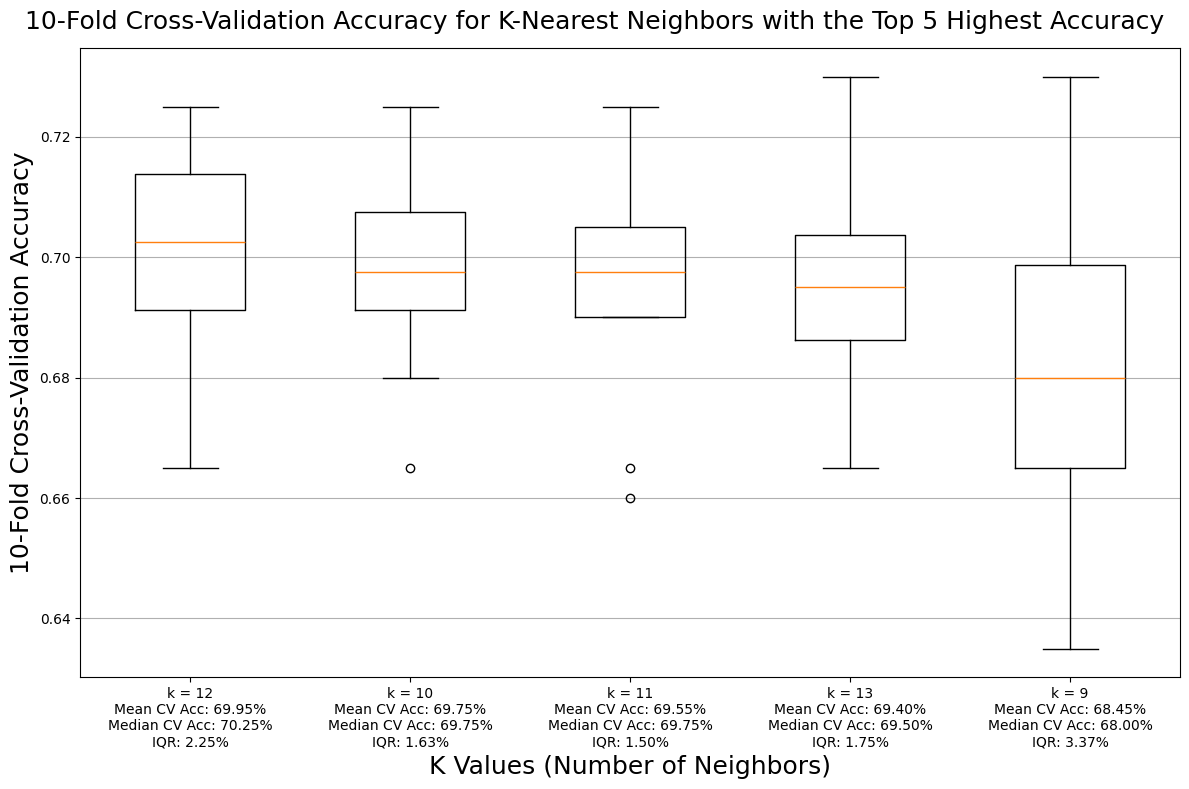

In [80]:
# Extract top 5 k values
top5_knn_kvals = list(knn_mean_accuracy_sorted.keys())[:5]

# Extract corresponding cross-validation scores
top5_knn_kf_cvs = {k: knn_kf_cvs[k] for k in top5_knn_kvals}

# Create box plot labels with k value, median, IQR, and mean accuracy
top5_knn_labels = []

for k, scores in top5_knn_kf_cvs.items():
    # Calculate IQR, median, and mean
    iqr = np.percentile(scores, 75) - np.percentile(scores, 25)
    median = np.median(scores)
    mean = np.mean(scores)

    # Construct label with k, mean, median, and IQR
    label = f'k = {k}\nMean CV Acc: {mean:.2%}\nMedian CV Acc: {median:.2%}\nIQR: {iqr:.2%}'
    top5_knn_labels.append(label)

# Generate box plots for these top 5 models
fig = plt.figure(figsize=(12,8))
fig.suptitle('10-Fold Cross-Validation Accuracy for K-Nearest Neighbors with the Top 5 Highest Accuracy', fontsize = 18)

# Create the box plot
plt.boxplot(top5_knn_kf_cvs.values(), labels=top5_knn_labels)

# Add labels and grid with font size of 18 for x and y labels
plt.grid(True, axis='y')
plt.xlabel('K Values (Number of Neighbors)', fontsize=18)
plt.ylabel('10-Fold Cross-Validation Accuracy', fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()

# QUESTION 7 - LOGISTIC REGRESSION USING 10-FOLD CROSS-VALIDATION

## Fit Logistic Regression

In [81]:
# initialize logistic regression object
logreg_cv = LogisticRegression()

# calculate the accuracy scores of each cv fold
logreg_kf_cvs = cross_val_score(logreg_cv, Xtrain, ytrain, cv = kf, scoring = 'accuracy')

# calculate the mean accuracy
logreg_cv_mean_accuracy = np.mean(logreg_kf_cvs)

print(f'Accuracy of Logistic Regression using Stratified 10-Fold Cross-Validation is {logreg_cv_mean_accuracy:.2%}.')

Accuracy of Logistic Regression using Stratified 10-Fold Cross-Validation is 71.15%.


# QUESTION 8 - LOGISTIC REGRESSION ON ENTIRE DATASET

## Fit Logistic Regression

In [82]:
# add a constant to training data
Xtrain_logreg = sm.add_constant(Xtrain)

# fit logistic regression
logreg = sm.Logit(ytrain, Xtrain_logreg).fit()

# print output summary
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.584003
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1993
Method:                           MLE   Df Model:                            6
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                 0.03300
Time:                        14:52:22   Log-Likelihood:                -1168.0
converged:                       True   LL-Null:                       -1207.9
Covariance Type:            nonrobust   LLR p-value:                 4.080e-15
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5752      0.592      0.972      0.331      -0.585       1.735
elpsdm         -0.0339    

## The Logistic Regression Model Developed

Model Equation

$$
\ln\left(\frac{p}{1-p}\right) = 0.5752 - 0.0339 \cdot \text{elpsdm} + 0.1739 \cdot \text{ordfreq} - 0.1230 \cdot \text{ordcat} + 0.1146 \cdot \log(\text{n24}) - 0.1063 \cdot \log(\text{rev24}) - 0.1460 \cdot \log(\text{revlast})
$$


Variance Significance:

* ordfreq

    * Coefficient = 0.1739 (positive impact): A unit increase in ordfreq (order frequency over the last 24 months) increases the odds by approximately 19%.

    * p-value = 0.002, indicating that this variable is significant at the 0.05 significance level.

* log_revlast

    * Coefficient = -0.1460 (negative impact): A unit increase in log_revlast (amount of last order ($)) decreases the odds by approximately 13.6%.

    * p-value = 0.391, which suggests log_revlast is not statistically significant at the 0.05 significance level, but it has the second greatest impact on the odds and predicted probabilities.

* elpsdm

    * Coefficient = -0.0339 (negative impact): A unit increase in elpsdm (time elapsed since last order (months)) decreases the odds by approximately 3.3%.

    * p-value = 0.010, indicating that elpsdm is significant at the 0.05 significance level, although the coefficient is the smallest in absolute value.

* Other variables have greater coefficients in absolute value but have p-values much greater than the significance level of 0.05.

## Accuracy

In [83]:
# get predicted probabilities
logreg_ytrain_pred_probs = logreg.predict(Xtrain_logreg)

# convert probabilities to binary predictions (assuming 0.5 threshold)
logreg_ytrain_pred = (logreg_ytrain_pred_probs >= 0.5).astype(int)

# calculate accuracy
logreg_train_accuracy = np.mean(logreg_ytrain_pred == ytrain)

print(f'Accuracy of the model on the training dataset is {logreg_train_accuracy:.2%}.')

Accuracy of the model on the training dataset is 71.45%.


# QUESTION 9 - PERFORM CROSS-VALIDATION ON THE BEST 4 MODELS (DECISION TREE, RANDOM FOREST, K-NEAREST NEIGHBORS, AND LOGISTIC REGRESSION)

## Best Decision Tree - Max Depth = 3

In [84]:
# initialize decision tree classifier
best_dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 1)

# get accuracy scores for each cv fold
best_dtree_scores = cross_val_score(best_dtree, Xtrain, ytrain, cv = kf, scoring = 'accuracy')
best_dtree_mean_accuracy = np.mean(best_dtree_scores)

# print accuracy
print(f'10-Fold Cross-Validation Accuracy for Decision Tree with Max Depth of 3 is {best_dtree_mean_accuracy:.2%}.')

10-Fold Cross-Validation Accuracy for Decision Tree with Max Depth of 3 is 70.40%.


## Best Random Forest - Number of Trees = 50, Max Depth = 3

In [85]:
# initialize random forest classifier
best_rf50 = RandomForestClassifier(n_estimators = 50, max_depth = 3, criterion = 'entropy', random_state = 1)

# get accuracy scores for each cv fold
best_rf50_scores = cross_val_score(best_rf50, Xtrain, ytrain, cv = kf, scoring = 'accuracy')
best_rf50_mean_accuracy = np.mean(best_rf50_scores)

# print accuracy
print(f'10-Fold Cross-Validation Accuracy for Random Forest with 50 Trees and Max Depth of 3 is {best_rf50_mean_accuracy:.2%}.')

10-Fold Cross-Validation Accuracy for Random Forest with 50 Trees and Max Depth of 3 is 70.65%.


## Best K-Nearest Neighbors - K = 12

---



In [86]:
# initialize KNN classifier
best_knn = KNeighborsClassifier(n_neighbors = 12)

# get accuracy scores for each cv fold
best_knn_scores = cross_val_score(best_knn, Xtrain, ytrain, cv = kf, scoring = 'accuracy')
best_knn_mean_accuracy = np.mean(best_knn_scores)

# print accuracy
print(f'10-Fold Cross-Validation Accuracy for K-Nearest Neighbors with k = 12 is {best_knn_mean_accuracy:.2%}.')

10-Fold Cross-Validation Accuracy for K-Nearest Neighbors with k = 12 is 69.95%.


## Best Logistic Regression - Stratified 10-Fold Cross-Validation

The best logistic regression model is the **logistic regression** model developed using **stratified 10-fold cross-validation**. This model generalizes better on new, unseen data. Despite the slightly lower training accuracy (compared to the logistic regression trained on the entire training dataset), it provides a more reliable estimate of future performance and reduces the risk of overfitting.

In [87]:
print(f'Accuracy of Logistic Regression using Stratified 10-Fold Cross-Validation is {logreg_cv_mean_accuracy:.2%}.')

Accuracy of Logistic Regression using Stratified 10-Fold Cross-Validation is 71.15%.


## Results

In [88]:
# define a dictionary to store the results
cv_results = {'Decision Tree': best_dtree_mean_accuracy,
              'Random Forest': best_rf50_mean_accuracy,
              'K-Nearest Neighbors': best_knn_mean_accuracy,
              'Logistic Regression': logreg_cv_mean_accuracy
}

# print results in a dataframe
cv_results_df = pd.DataFrame(cv_results.items(), columns = ['Model Type', 'Stratified 10-Fold Cross-Validation Accuracy'])
cv_results_df['Stratified 10-Fold Cross-Validation Accuracy'] = cv_results_df['Stratified 10-Fold Cross-Validation Accuracy'].map('{:.2%}'.format) # format accuracy as percentage

# calculate the max width of each column for alignment
model_col_width = max(cv_results_df['Model Type'].str.len().max(), len('Model Type'))
accuracy_col_width = max(cv_results_df['Stratified 10-Fold Cross-Validation Accuracy'].str.len().max(), len('Stratified 10-Fold Cross-Validation Accuracy'))

# print header with center alignment
header = f"{'Model Type'.center(model_col_width)} | {'Stratified 10-Fold Cross-Validation Accuracy'.center(accuracy_col_width)}"
print(header)
print('-' * len(header))

# print each row with center alignment
for idx, row in cv_results_df.iterrows():
    model_type = row['Model Type'].center(model_col_width)
    accuracy = row['Stratified 10-Fold Cross-Validation Accuracy'].center(accuracy_col_width)
    print(f"{model_type} | {accuracy}")

     Model Type     | Stratified 10-Fold Cross-Validation Accuracy
------------------------------------------------------------------
   Decision Tree    |                    70.40%                   
   Random Forest    |                    70.65%                   
K-Nearest Neighbors |                    69.95%                   
Logistic Regression |                    71.15%                   


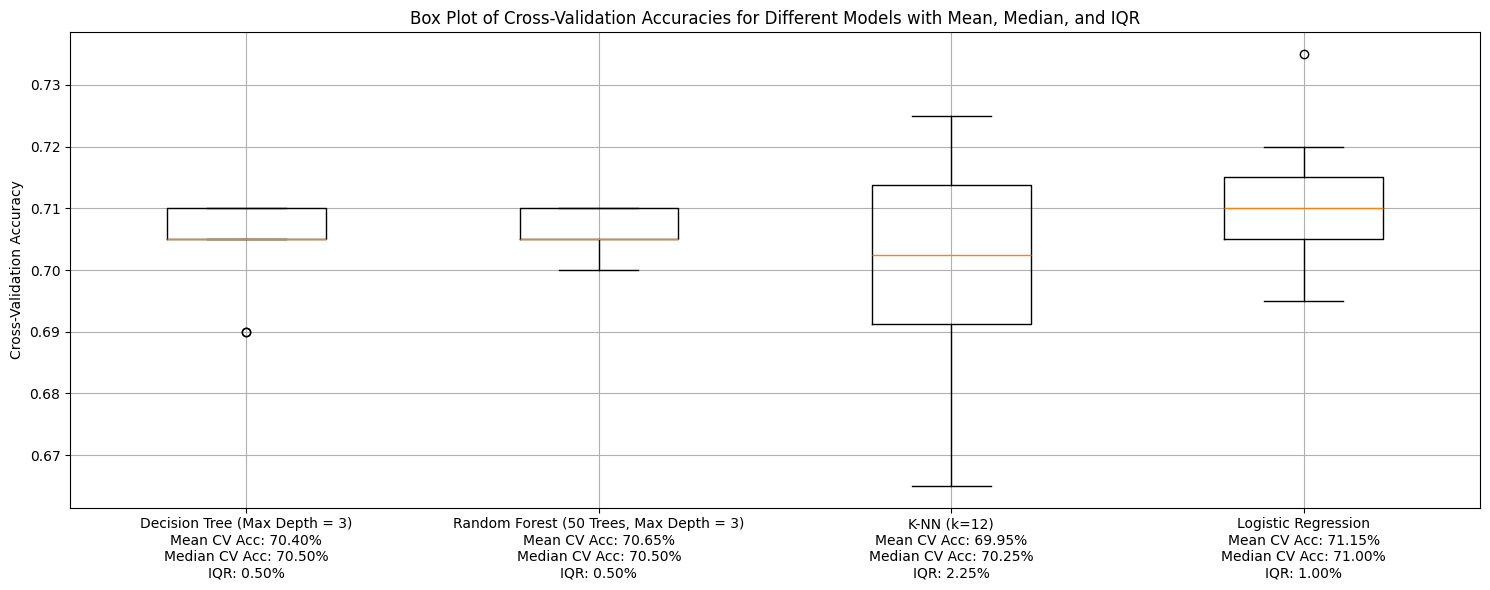

In [89]:
# Initialize Decision Tree classifier
best_dtree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)
best_dtree_scores = cross_val_score(best_dtree, Xtrain, ytrain, cv=kf, scoring='accuracy')
best_dtree_mean_accuracy = np.mean(best_dtree_scores)

# Initialize Random Forest classifier (50 trees, max depth 3)
best_rf50 = RandomForestClassifier(n_estimators=50, max_depth=3, criterion='entropy', random_state=1)
best_rf50_scores = cross_val_score(best_rf50, Xtrain, ytrain, cv=kf, scoring='accuracy')
best_rf50_mean_accuracy = np.mean(best_rf50_scores)

# Initialize K-Nearest Neighbors classifier (k=12)
best_knn = KNeighborsClassifier(n_neighbors=12)
best_knn_scores = cross_val_score(best_knn, Xtrain, ytrain, cv=kf, scoring='accuracy')
best_knn_mean_accuracy = np.mean(best_knn_scores)

# Initialize Logistic Regression model
logreg_cv = LogisticRegression()
logreg_cv_scores = cross_val_score(logreg_cv, Xtrain, ytrain, cv=kf, scoring='accuracy')
logreg_cv_mean_accuracy = np.mean(logreg_cv_scores)

# Combine the cross-validation scores into one list for the boxplot
model_scores = [best_dtree_scores, best_rf50_scores, best_knn_scores, logreg_cv_scores]
model_labels = ['Decision Tree (Max Depth = 3)', 'Random Forest (50 Trees, Max Depth = 3)', 'K-NN (k=12)', 'Logistic Regression']

# Calculate Mean, IQR, and Median for each model
custom_labels = []
for i, scores in enumerate(model_scores):
    mean = np.mean(scores)
    median = np.median(scores)
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqr = q3 - q1
    custom_labels.append(f'{model_labels[i]}\nMean CV Acc: {mean:.2%}\nMedian CV Acc: {median:.2%}\nIQR: {iqr:.2%}')

# Box plots for the cross-validation scores of the models
plt.figure(figsize=(15,6))

# Plot the box plots
plt.boxplot(model_scores, labels=custom_labels)

# Add labels and title
plt.title('Box Plot of Cross-Validation Accuracies for Different Models with Mean, Median, and IQR')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)

# Show the box plot
plt.tight_layout()
plt.show()

# QUESTION 10 - FINAL MODEL ON ENTIRE TRAINING DATASET

In [90]:
#Train the final model on the entire training dataset
logreg_cv = LogisticRegression()  # Create the logistic regression model
logreg_cv.fit(Xtrain, ytrain)

print(f'Accuracy of Logistic Regression using Stratified 10-Fold Cross-Validation is {logreg_cv_mean_accuracy:.2%}.')

Accuracy of Logistic Regression using Stratified 10-Fold Cross-Validation is 71.15%.


# QUESTION 11 - FINAL MODEL ON TEST DATASET

## Explore Test Data

In [91]:
# import test data and save as pandas dataframe
testdf = pd.read_csv('dmtest.csv')
# show first 5 rows
print(testdf.head())
# dimensions
print('Dimensions of the test dataset:', testdf.shape)

     id  n24  rev24  revlast  elpsdm  ordfreq  ordcat
0  5001    5  186.0       18      24        1       6
1  5002    2   30.0       15      24        1       6
2  5003   24  362.0       30      24        1       7
3  5004    4   41.0       15      24        1       6
4  5005    5   59.0       18      24        1       6
Dimensions of the test dataset: (2000, 7)


In [92]:
# check for zero values
print((testdf[['n24', 'rev24', 'revlast']] <= 0).any())

n24        False
rev24      False
revlast     True
dtype: bool


## Apply Log-Transformation and Drop Original Variables 'n24', 'rev24', 'revlast'

In [93]:
# Apply same log-transformation as in training data
testdf['log_n24'] = np.log(testdf['n24'])
testdf['log_rev24'] = np.log(testdf['rev24'])
testdf['log_revlast'] = np.log1p(testdf['revlast'])

In [94]:
# drop original variables
testdf = testdf.drop(['n24', 'rev24', 'revlast'], axis = 1)
print(testdf.head())

     id  elpsdm  ordfreq  ordcat   log_n24  log_rev24  log_revlast
0  5001      24        1       6  1.609438   5.225747     2.944439
1  5002      24        1       6  0.693147   3.401197     2.772589
2  5003      24        1       7  3.178054   5.891644     3.433987
3  5004      24        1       6  1.386294   3.713572     2.772589
4  5005      24        1       6  1.609438   4.077537     2.944439


## Logistic Regression

In [95]:
# define independent variables
Xtest = testdf.copy()
Xtest = Xtest.drop(['id'], axis = 1)

Xtest

,elpsdm,ordfreq,ordcat,log_n24,log_rev24,log_revlast
0,24,1,6,1.609438,5.225747,2.944439
1,24,1,6,0.693147,3.401197,2.772589
2,24,1,7,3.178054,5.891644,3.433987
3,24,1,6,1.386294,3.713572,2.772589
4,24,1,6,1.609438,4.077537,2.944439
...,...,...,...,...,...,...
1995,1,1,7,2.197225,5.105945,0.000000
1996,1,3,6,2.397895,5.003946,2.772589
1997,1,2,5,2.890372,5.081404,2.639057
1998,1,4,7,3.258097,6.056784,3.258097


In [96]:
#Make predictions using the logistic regression model trained earlier
predictions = logreg_cv.predict(Xtest)
testdf['prediction'] = predictions
testdf

,id,elpsdm,ordfreq,ordcat,log_n24,log_rev24,log_revlast,prediction
0,5001,24,1,6,1.609438,5.225747,2.944439,0
1,5002,24,1,6,0.693147,3.401197,2.772589,0
2,5003,24,1,7,3.178054,5.891644,3.433987,0
3,5004,24,1,6,1.386294,3.713572,2.772589,0
4,5005,24,1,6,1.609438,4.077537,2.944439,0
...,...,...,...,...,...,...,...,...
1995,6996,1,1,7,2.197225,5.105945,0.000000,0
1996,6997,1,3,6,2.397895,5.003946,2.772589,0
1997,6998,1,2,5,2.890372,5.081404,2.639057,0
1998,6999,1,4,7,3.258097,6.056784,3.258097,0


In [97]:
# print prediction value counts
count_of_responders = (testdf['prediction'] == 1).sum()
count_of_non_responders = (testdf['prediction'] == 0).sum()

print(f"\nNumber of customers likely to respond: {count_of_responders}")
print(f"Number of customers unlikely to respond: {count_of_non_responders}\n")


Number of customers likely to respond: 29
Number of customers unlikely to respond: 1971



In [98]:
# Save the DataFrame to a CSV file locally
testdf.to_csv('group07dmtest.csv', index=False)

# Inform the user that the file has been saved
print("CSV file 'group07dmtest.csv' has been saved locally.")

CSV file 'group07dmtest.csv' has been saved locally.


# QUESTION 12 - MODEL PERFORMANCE ON LAPSING CUSTOMERS AND NON-LAPSING CUSTOMERS

## Define Lapsing and Non-Lapsing Customer Groups

In [99]:
# define 'lapsing customers' with elpsdm between 13 and 24
lapsing_customers = traindf[(traindf['elpsdm'] >= 13) & (traindf['elpsdm'] <= 24)]

# define 'non-lapsing customers' as the remaining group
nonlapsing_customers = traindf[(traindf['elpsdm'] < 13)]

print(f'There are {lapsing_customers.shape[0]} lapsing customers and {nonlapsing_customers.shape[0]} non-lapsing customers.')

There are 1653 lapsing customers and 347 non-lapsing customers.


## Make Predictions and Calculate Accuracy for Both Groups

In [100]:
# define target variable and independent variables for both groups
y_lapsing = lapsing_customers['response']
X_lapsing = lapsing_customers.copy().drop(['id', 'response'], axis = 1)

y_nonlapsing = nonlapsing_customers['response']
X_nonlapsing = nonlapsing_customers.copy().drop(['id', 'response'], axis = 1)

In [101]:
# make predictions
lapsing_pred = logreg_cv.predict(X_lapsing)
nonlapsing_pred = logreg_cv.predict(X_nonlapsing)

# calculate accuracy
lapsing_accuracy = accuracy_score(y_lapsing, lapsing_pred)
nonlapsing_accuracy = accuracy_score(y_nonlapsing, nonlapsing_pred)

print(f'Accuracy for lapsing customers is {lapsing_accuracy:.2%}.')
print(f'Accuracy for non-lapsing customers is {nonlapsing_accuracy:.2%}.')

Accuracy for lapsing customers is 72.41%.
Accuracy for non-lapsing customers is 66.86%.
